### Single-input Network - PyTorch

Predicts the action given a single observation (checks whether the Dataset is 'difficult' to learn)

In [1]:
'''
Imports external and own libraries
'''

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [ ]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)

In [ ]:
'''
Use Dataloader to make the data ready for the training loop
'''

train_data, test_data = preprocess.split_data(oracle_random_data, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDataset(train_data, 'observations', 'actions')
oracle_test_data = preprocess.ObtainDataset(test_data, 'observations', 'actions')

# build dataloader (tensor format)
batch_size = 64
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

In [ ]:
'''
Visualize one batch
'''

# next data part
dataiter = iter(dataset_loader_train_data)
# plot 64 examples
images, labels = dataiter.next()
plot.plot_64_observations(images)

In [ ]:
'''
Feed-forward network
'''

forward = nets.Forward()
summary(forward, (3,32,32))

In [ ]:
'''
Train the network
- best ever obtained training acc: 64% (test acc was at 17%) - for small dataset (2000)
- best obtained training acc: 
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(forward.parameters(), lr=0.001) #, momentum=0.9) # for small one 0.01 works well

episodes = 500
forward, train_loss, test_loss, train_acc, test_acc  = train.train(dataset_loader_train_data, dataset_loader_test_data, forward, criterion, optimizer, episodes)


In [ ]:
'''
Plot loss and accuracy curves for training and test set
'''

plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=True)

In [ ]:
'''
Show example classifications and plot confusion matrix
'''

plot.show_example_classificataions(dataset_loader_train_data, forward, amount=8)
plot.plot_confusion_matrix(dataset_loader_train_data, forward)

In [ ]:
'''
Save and load model
'''

# Save
torch.save(model, 'models/Feedforward_overfitted.pt')

# Load
#model = torch.load('models/Feedforward.pt')
#model.eval()

### Single-input Network - PyTorch (difference image)

In [25]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)

In [26]:
'''
Use Dataloader to make the data ready for the training loop
'''

dataset = preprocess.split_n_steps_between(oracle_reversed_data, n=3)
train_data, test_data = preprocess.split_data(dataset, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDualDataset(train_data, 'observationsA','observationsB', 'actions')
oracle_test_data = preprocess.ObtainDualDataset(test_data, 'observationsA','observationsB', 'actions')

# build dataloader (tensor format)
batch_size = 64
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

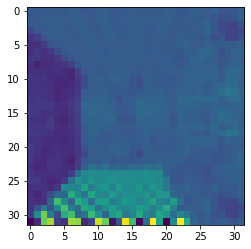

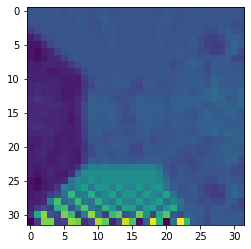

[3, 3, 3]


In [45]:
imagesA, imagesB, labels = next(iter(oracle_train_data))

from matplotlib import pyplot as plt

plt.imshow(imagesA[0])
plt.show()

plt.imshow(imagesB[0])
plt.show()

print(labels)

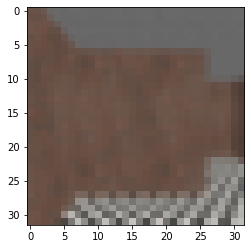

['walk backwards', 'walk backwards', 'walk backwards']


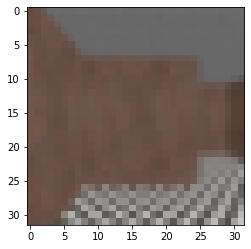

In [36]:
import torchvision
import torch
from matplotlib import pyplot as plt

classes_expl = {0: 'turn left', 1: 'turn right', 2: 'walk forwards', 3: 'walk backwards'}

index = 502

imageA = dataset['observationsA'][index]
imageB = dataset['observationsB'][index]
lstval = [classes_expl[key] for key in dataset['actions'][index]]

plt.imshow(imageA)
plt.show()

print(lstval)

plt.imshow(imageB)
plt.show()

# look into tensor directly: plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

In [42]:
print(dataset['actions'][17])

# labels break during processing in datagenerator! need to conserve their structure
# one-hot encoding?

[2, 2, 2]


In [37]:
'''
Feed-forward network
'''

forward = nets.Forward()
summary(forward, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 4]             340
Total params: 61,496
Trainable params: 61,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [40]:
import torch
import plot
from tqdm.auto import tqdm

import torchvision
from torch.utils.tensorboard import SummaryWriter

def train(train_data, val_data, net, criterion, optimizer, steps):
    '''
    Main training loop
    Input: dataset_loader, network, training_loss, optimizer, step size
    Output: trained network
    '''

    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    with tqdm(total=steps, unit =" Episode", desc ="Progress") as pbar:
        for epoch in range(steps):  # loop over the dataset multiple times

            train_running_loss = 0.0

            train_correct = 0
            train_total = 0

            for i, data in enumerate(train_data, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputsA, inputsB, labels = data
                print('labels', labels)
                labels = labels[0]
                labels = labels.to(torch.long)
                
                inputs = inputsB - inputsA

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # compute acc
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # track loss statistics
                train_running_loss += loss.item()

                test_running_loss = 0.0

                test_correct = 0
                test_total = 0

                # same for validation set
                with torch.no_grad():
                    for data in val_data:
                        inputsA, inputsB, labels = data
                        labels = labels[0]
                        labels = labels.to(torch.long)
                        
                        inputs = inputsB - inputsA
                        
                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
                        test_running_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        test_total += labels.size(0)
                        test_correct += (predicted == labels).sum().item()

            train_loss.append(train_running_loss/len(train_data))
            test_loss.append(test_running_loss/len(val_data))
            train_acc.append(100 * train_correct / train_total)
            test_acc.append(100 * test_correct / test_total)
            pbar.update(1)

            if epoch % 10 == 0:
                print(f'Epoch: {epoch + 1}, Train Loss: {(train_running_loss/len(train_data)):.4}, Train Acc: {(100 * train_correct / train_total):.4} %,  Test Loss: {(test_running_loss/len(val_data)):.4}, Test Acc: {(100 * test_correct / test_total):.4} %,')

    print('Finished Training')
    return net, train_loss, test_loss, train_acc, test_acc

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(forward.parameters(), lr=0.001) #, momentum=0.9) # for small one 0.01 works well

episodes = 1
forward, train_loss, test_loss, train_acc, test_acc  = train(dataset_loader_train_data, dataset_loader_test_data, forward, criterion, optimizer, episodes)

Progress:   0%|          | 0/1 [00:00<?, ? Episode/s]

labels [tensor([2, 1, 2, 0, 2, 0, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 0, 2, 3, 2, 3, 1, 3,
        3, 2, 3, 2, 3, 3, 2, 0, 2, 0, 3, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2,
        1, 3, 0, 2, 3, 2, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3]), tensor([2, 3, 2, 0, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 0, 2, 3, 2, 3, 1, 3,
        3, 2, 3, 2, 3, 3, 2, 0, 2, 0, 3, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2,
        1, 3, 0, 2, 3, 2, 0, 2, 2, 3, 3, 0, 3, 3, 3, 3]), tensor([2, 3, 2, 0, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 0, 2, 3, 2, 3, 1, 3,
        3, 2, 3, 2, 3, 3, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2,
        1, 3, 0, 2, 3, 2, 3, 2, 2, 3, 3, 0, 1, 3, 3, 3])]
labels [tensor([3, 2, 2, 1, 3, 2, 3, 1, 2, 3, 0, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 1, 3, 2, 2, 3, 0, 2, 2, 1, 3,
        3, 2, 2, 0, 3, 2, 3, 3, 0, 3, 3, 3, 2, 3, 3, 2]), tensor([3, 2, 2, 1, 3, 2, 3, 1, 2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 1, 3, 0, 3,
        3, 2, 2, 2, 3, 3, 3, 2, 

labels [tensor([2, 2, 2, 0, 3, 3, 3, 1, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2,
        2, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 2, 0, 2, 3, 2, 2, 2, 2, 2, 0, 2, 3, 1,
        3, 2, 0, 2, 2, 0, 2, 2, 3, 3, 3, 2, 1, 3, 2, 2]), tensor([2, 2, 2, 0, 3, 3, 3, 1, 0, 3, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2,
        2, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 2, 0, 2, 3, 2, 2, 2, 2, 2, 0, 2, 3, 3,
        3, 2, 3, 2, 2, 0, 2, 2, 3, 3, 3, 2, 1, 3, 2, 2]), tensor([2, 1, 2, 2, 3, 3, 3, 1, 0, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2,
        2, 3, 3, 3, 1, 3, 1, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 0, 2, 3, 3,
        3, 2, 3, 2, 2, 0, 2, 2, 0, 3, 3, 2, 1, 3, 1, 2])]
labels [tensor([3, 2, 3, 0, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 0, 3, 2, 3, 3, 3, 3, 2, 2,
        3, 2, 3, 2, 1, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 0, 3, 2, 3, 3, 0, 2, 2,
        3, 3, 2, 3, 1, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3]), tensor([3, 2, 3, 0, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 0, 3, 2, 3, 3, 3, 3, 1, 2,
        3, 2, 3, 2, 1, 3, 2, 3, 

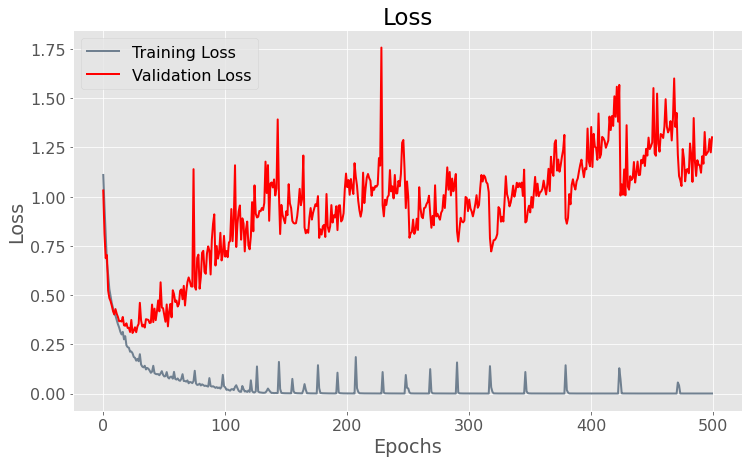

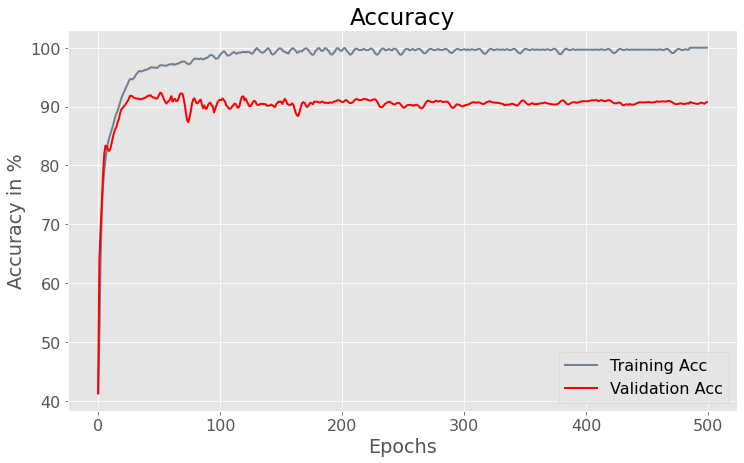

In [22]:
'''
Plot loss and accuracy curves for training and test set
'''

plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=True)